In [13]:
# !ls -hl|grep csv
import pandas as pd
import numpy as np
import os
from time import time, ctime

from sklearn.metrics import accuracy_score, classification_report, classification, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, StratifiedShuffleSplit

from helper import plot_confusion_matrix, plot_confusion_matrix2
dim=lambda *x: [i.shape for i in x]

In [14]:
import os
import tensorflow as tf
from tensorflow.python.client import device_lib

from keras import backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

K.set_session(sess)

# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10585739437251976968
]


In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import os
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [16]:
%%time
df = pd.read_csv('./prepared_for_GPU.csv')
print(df.shape)

(34219, 853)
CPU times: user 2.26 s, sys: 153 ms, total: 2.42 s
Wall time: 2.41 s


In [17]:
cat_index= [0, 1, 2, 3, 4, 747, 748, 749, 757, 766, 767, 768, 769, 770, 771, 774, 
            775, 836, 837, 838, 839, 840, 841, 842, 843, 846, 847, 848, 849, 850]
len(cat_index)

30

In [18]:
X=df.iloc[:, 2:]
y=df.iloc[:, 1].values

In [19]:
X.iloc[:,cat_index].head()

,username_split_predict,last,last_two,first,first2,about.company,about.hourly_rate,about.primary_language,Month,city_3,...,identity_verified,payment_verified,phone_verified,profile_complete,country_5,timezone_5,pred_about.username_sentence,pred_about.username,pred_about.display_name,pred_about.public_name
0,1,22,659,0,0,26,124,5,2,559,...,1,2,1,2,169,220,1,1,1,1
1,2,14,284,0,0,19537,124,5,5,8503,...,1,1,1,2,14,194,2,2,2,2
2,0,22,694,0,0,337,124,5,1,4700,...,1,1,1,1,170,57,0,0,0,0
3,2,23,362,0,1,19538,124,5,7,5797,...,1,1,1,2,170,95,2,2,2,2
4,2,28,559,0,1,26,124,5,8,307,...,1,1,1,2,170,95,2,2,2,2


In [20]:
# for i in X.iloc[:,cat_index]:
#     print (i, len(X[i].unique()))

In [21]:
%%time
from sklearn.preprocessing import OneHotEncoder
print (X.shape)
onehotencoder = OneHotEncoder(categorical_features = cat_index)
X = onehotencoder.fit_transform(X).toarray()
print (X.shape)

(34219, 851)
(34219, 37603)
CPU times: user 2.06 s, sys: 1.96 s, total: 4.02 s
Wall time: 4.02 s


In [22]:
%%time
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X=sc.fit_transform(X)
print (X.shape)

(34219, 37603)
CPU times: user 16.6 s, sys: 8.76 s, total: 25.4 s
Wall time: 25.4 s


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   random_state=7)
dim(X_train, X_test, y_train, y_test)

[(23953, 37603), (10266, 37603), (23953,), (10266,)]

In [24]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# # fit on training set
# X_train = sc.fit_transform(X_train)
# # only transform on test set
# X_test = sc.transform(X_test)
# print dim(X_train,X_test, y_train, y_test)

In [25]:
classifier = Sequential()
# first hidden layer
classifier.add(Dense(units = 128, 
                     input_dim=37603,
                     kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(rate= 0.5))
# second hidden layer
classifier.add(Dense(units = 128,  kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(rate= 0.4))
# second hidden layer
classifier.add(Dense(units = 128,  kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(rate= 0.3))
# thrid hidden layer
classifier.add(Dense(units = 128,  kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(rate= 0.2))
# thrid hidden layer
classifier.add(Dense(units = 128,  kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(rate= 0.1))
# # ouput layer
classifier.add(Dense(units = 1,  kernel_initializer='uniform', activation='sigmoid'))
# compiling the ANN
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               4813312   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

In [26]:
from keras.callbacks import Callback, EarlyStopping
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=1)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [27]:
stopping = EarlyStopping(monitor='acc', min_delta=0,
                              patience=16, verbose=1, mode='auto')

In [28]:
# fitting ANN with training set
classifier.fit(X_train, y_train, 
               batch_size=96, epochs=300,
               validation_data=(X_test, y_test),
#           callbacks=[TestCallback((X_test, y_test))])
          callbacks=[stopping])
    


Train on 23953 samples, validate on 10266 samples
Epoch 1/300
23953/23953 [==============================] - 10s - loss: 0.4590 - acc: 0.8299 - val_loss: 0.4381 - val_acc: 0.8323
Epoch 2/300
23953/23953 [==============================] - 9s - loss: 0.3466 - acc: 0.8455 - val_loss: 0.4601 - val_acc: 0.8336
Epoch 3/300
23953/23953 [==============================] - 9s - loss: 0.1831 - acc: 0.9287 - val_loss: 0.5145 - val_acc: 0.8201
Epoch 4/300
23953/23953 [==============================] - 9s - loss: 0.0825 - acc: 0.9686 - val_loss: 0.7834 - val_acc: 0.8179
Epoch 5/300
23953/23953 [==============================] - 9s - loss: 0.0525 - acc: 0.9798 - val_loss: 0.9328 - val_acc: 0.8179
Epoch 6/300
23953/23953 [==============================] - 9s - loss: 0.0375 - acc: 0.9866 - val_loss: 1.1134 - val_acc: 0.8035
Epoch 7/300
23953/23953 [==============================] - 9s - loss: 0.0248 - acc: 0.9908 - val_loss: 1.2419 - val_acc: 0.8060
Epoch 8/300
23953/23953 [============================

23953/23953 [==============================] - 9s - loss: 0.0048 - acc: 0.9984 - val_loss: 1.9916 - val_acc: 0.8111
Epoch 64/300
23953/23953 [==============================] - 9s - loss: 0.0052 - acc: 0.9989 - val_loss: 2.2280 - val_acc: 0.8206
Epoch 65/300
23953/23953 [==============================] - 9s - loss: 0.0039 - acc: 0.9988 - val_loss: 2.1605 - val_acc: 0.8160
Epoch 66/300
23953/23953 [==============================] - 9s - loss: 0.0063 - acc: 0.9983 - val_loss: 2.0667 - val_acc: 0.8156
Epoch 67/300
23953/23953 [==============================] - 9s - loss: 0.0051 - acc: 0.9982 - val_loss: 2.0611 - val_acc: 0.8139
Epoch 00066: early stopping


0.808007013442
Confusion matrix, without normalization
[[ 372 1350]
 [ 621 7923]]


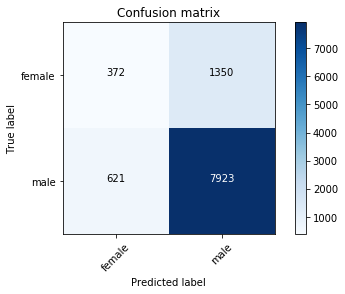

In [61]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred> 0.5)

print (accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['female','male'])